1. Check whether decoding latent vectors that are drawn from the prior distribution yields reasonable sequences.
2. Check whether we can accurately reconstruct sequences after encoding them (i.e. encode sequence, then decode back, then check whether we get something close to what we started with)

## Preliminaries

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/Shareddrives/vae-asr/

Mounted at /content/drive
/content/drive/Shareddrives/vae-asr


In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pickle
import torch
import pandas
import sys
sys.path.append('/content/drive/Shareddrives/vae-asr/modules')
# from model import VAE
# help(VAE)
from data import MSA_Dataset
# help(MSA_Dataset)

In [3]:
MSA_id = "PF00067"

Load binarized MSA

In [4]:
## read multiple sequence alignment in binary representation
with open(f"./output/{MSA_id}_full/seq_msa_binary.pkl", 'rb') as file_handle:
    msa_binary = torch.tensor(pickle.load(file_handle))
# Number of sequences
n_real_seq = msa_binary.shape[0]
# Dimensions of one-hot encoding
nl = msa_binary.shape[1]
nc = msa_binary.shape[2]
# Print shape
msa_binary.shape

torch.Size([9767, 107, 21])

In [5]:
import torch.nn as nn
import torch.nn.functional as F

class LSTM_VAE(nn.Module):
    def __init__(self, nl, nc=21, dim_latent_vars=10, num_hidden_units=[256, 256]):
        """
        Our default is that the latent embeddings are dimension 10 and there are
        256 neurons in each of the hidden layers of the encoder and decoder
        """
        super(LSTM_VAE, self).__init__()

        ## num of amino acid types
        self.nc = nc

        ## length of sequences in the MSA
        self.nl = nl

        ## dimension of input
        self.dim_input = nc * nl

        ## dimension of latent space
        self.dim_latent_vars = dim_latent_vars

        ## num of hidden neurons in encoder and decoder networks
        self.num_hidden_units = num_hidden_units

        ## encoder
        # self.encoder_linears = nn.ModuleList()
        # self.encoder_linears.append(nn.Linear(self.dim_input, num_hidden_units[0]))
        # for i in range(1, len(num_hidden_units)):
        #     self.encoder_linears.append(nn.Linear(num_hidden_units[i-1], num_hidden_units[i]))

        # self.encoder_lstm = nn.LSTM(self.nc, num_hidden_units[0], 1, batch_first=True)
        # self.encoder_mu = nn.Linear(num_hidden_units[-1], dim_latent_vars)
        # self.encoder_logsigma = nn.Linear(num_hidden_units[-1], dim_latent_vars)
        self.encoder_lstm_mu = nn.LSTM(self.nc, dim_latent_vars, 1, batch_first=True)
        self.encoder_lstm_sigma = nn.LSTM(self.nc, dim_latent_vars, 1, batch_first=True)

        ## decoder
        self.decoder_linears = nn.ModuleList()
        self.decoder_linears.append(nn.Linear(dim_latent_vars, num_hidden_units[0]))
        for i in range(1, len(num_hidden_units)):
            self.decoder_linears.append(nn.Linear(num_hidden_units[i-1], num_hidden_units[i]))
        self.decoder_linears.append(nn.Linear(num_hidden_units[-1], self.dim_input))

    def encoder(self, x):
        '''
        encoder transforms x into latent space z
        '''
        # convert from matrix to vector by concatenating rows (which are one-hot vectors)
        # h = torch.flatten(x, start_dim=-2) # start_dim=-2 to maintain batch dimension
        # for T in self.encoder_linears:
        #     h = T(h)
        #     h = F.relu(h)

        # h, _ = self.encoder_lstm(x)
        # h = h[:, -1, :]
        # mu = self.encoder_mu(h)
        # sigma = torch.exp(self.encoder_logsigma(h))

        mu, _ = self.encoder_lstm_mu(x)
        mu = mu[:, -1, :]
        sigma, _ = self.encoder_lstm_sigma(x)
        sigma = torch.exp(sigma[:, -1, :])
        return mu, sigma

    def decoder(self, z):
        '''
        decoder transforms latent space z into p, which is the probability  of x being 1.
        '''
        h = z
        for i in range(len(self.decoder_linears)-1):
            h = self.decoder_linears[i](h)
            h = F.relu(h)
        h = self.decoder_linears[-1](h) #Should now have dimension nc*nl

        fixed_shape = tuple(h.shape[0:-1])
        h = torch.unsqueeze(h, -1)
        h = torch.reshape(h, fixed_shape + (-1, self.nc))
        log_p = F.log_softmax(h, dim = -1)
        #log_p = torch.reshape(log_p, fixed_shape + (-1,))

        return log_p

    def compute_weighted_elbo(self, x, weight):
        ## sample z from q(z|x)
        mu, sigma = self.encoder(x)
        eps = torch.randn_like(sigma)
        z = mu + sigma*eps

        ## compute log p(x|z)
        log_p = self.decoder(z)
        log_PxGz = torch.sum(x*log_p, [-1,-2]) # sum over both position and character dimension

        ## compute elbo
        elbo = log_PxGz - torch.sum(0.5*(sigma**2 + mu**2 - 2*torch.log(sigma) - 1), -1)
        weight = weight / torch.sum(weight)
        elbo = torch.sum(elbo*weight)

        return elbo

    def compute_elbo_with_multiple_samples(self, x, num_samples):
        '''
        Evidence lower bound is an lower bound of log P(x). Although it is a lower
        bound, we can use elbo to approximate log P(x).
        Using multiple samples to calculate the elbo makes it be a better approximation
        of log P(x).
        '''

        with torch.no_grad():
            # x = x.expand(num_samples, x.shape[0], x.shape[1], x.shape[2])
            mu, sigma = self.encoder(x)
            eps = torch.randn_like(mu)
            z = mu + sigma * eps
            log_Pz = torch.sum(-0.5*z**2 - 0.5*torch.log(2*z.new_tensor(np.pi)), -1)
            log_p = self.decoder(z)
            log_PxGz = torch.sum(x*log_p, [-1,-2]) # sum over both position and character dimension
            log_Pxz = log_Pz + log_PxGz

            log_QzGx = torch.sum(-0.5*(eps)**2 -
                                 0.5*torch.log(2*z.new_tensor(np.pi))
                                 - torch.log(sigma), -1)
            log_weight = (log_Pxz - log_QzGx).detach().data
            log_weight = log_weight.double()
            log_weight_max = torch.max(log_weight, 0)[0]
            log_weight = log_weight - log_weight_max
            weight = torch.exp(log_weight)
            elbo = torch.log(torch.mean(weight, 0)) + log_weight_max
            return elbo


Load model

In [22]:
dim = 64
epo = 500

model = LSTM_VAE(nl = nl, nc = nc, dim_latent_vars=dim)
model_state_dict = torch.load(f"./lstm_output/{MSA_id}_full/vae_fold2_dimlat{64}_{epo}_0.01.model")
model.load_state_dict(model_state_dict)

<All keys matched successfully>

Load mapping between integers and amino acid characters

In [8]:
with open(f"./output/{MSA_id}_full/aa_index.pkl", 'rb') as file_handle:
    aa_index = pickle.load(file_handle)
# In our integer encoding of proteins, we've encoded 3 different amino acid characters as 0: '-', '.', and 'B'
# For decoding purposes, we will decode all 0's as '.'
del aa_index['-'], aa_index['B']

# now let's create the inverse mapping
idx_to_aa_dict = {}
idx_to_aa_list = ['' for i in range(nc)]
for k, v in aa_index.items():
    idx_to_aa_dict[v] = k
    idx_to_aa_list[v] = k

# Part 1: Decoding draws from the prior

In [23]:
# draws from the prior to be decoded
# z has to be a torch.tensor with a size of (num_seqs, dim_latent_space)
num_seqs = 25
dim_latent_space = model.dim_latent_vars
z = torch.randn(num_seqs, dim_latent_space)

# decode to amino acid probabilities
with torch.no_grad():
    log_p = model.decoder(z)
    p = torch.exp(log_p)
p = p.numpy()
p.shape

(25, 107, 21)

In [24]:
# covert probablities into actual protein sequences by choosing the most likely amino acid at each position.
max_prob_idx = np.argmax(p, -1)
seqs = []
for i in range(num_seqs):
    seq = [idx_to_aa_list[idx] for idx in max_prob_idx[i,:]]
    print("".join(seq))
    seqs.append("".join(seq))

KLREEIDEVLGDDRLPTEEDLKKLPYLDAVIKETLRLYPPVPGLPREATEDTTLGGYTIPKGTTVLVNIWAIHRDPEVWPDPEEFDPERFLDENG.KGPPFALLL..
KLREEIDEVLGDDRLPTEEDLKKLPYLDAVIKETLRLYPPVPGLPREATEDTTLGGYTIPKGTTVLVNIWAIHRDPEVWPDPEEFDPERFLDENG.KGPPFALLL..
KLREEIDEVLGDDRLPTEEDLKKLPYLDAVIKETLRLYPPVPGLPREATEDTTLGGYTIPKGTTVLVNIWAIHRDPEVWPDPEEFDPERFLDENG.KGPPFALLL..
KLREEIDEVLGDDRLPTEEDLKKLPYLDAVIKETLRLYPPVPGLPREATEDTTLGGYTIPKGTTVLVNIWAIHRDPEVWPDPEEFDPERFLDENG.KGPPFALLL..
KLREEIDEVLGDDRLPTEEDLKKLPYLDAVIKETLRLYPPVPGLPREATEDTTLGGYTIPKGTTVLVNIWAIHRDPEVWPDPEEFDPERFLDENG.KGPPFALLL..
KLREEIDEVLGDDRLPTEEDLKKLPYLDAVIKETLRLYPPVPGLPREATEDTTLGGYTIPKGTTVLVNIWAIHRDPEVWPDPEEFDPERFLDENG.KGPPFALLL..
KLREEIDEVLGDDRLPTEEDLKKLPYLDAVIKETLRLYPPVPGLPREATEDTTLGGYTIPKGTTVLVNIWAIHRDPEVWPDPEEFDPERFLDENG.KGPPFALLL..
KLREEIDEVLGDDRLPTEEDLKKLPYLDAVIKETLRLYPPVPGLPREATEDTTLGGYTIPKGTTVLVNIWAIHRDPEVWPDPEEFDPERFLDENG.KGPPFALLL..
KLREEIDEVLGDDRLPTEEDLKKLPYLDAVIKETLRLYPPVPGLPREATEDTTLGGYTIPKGTTVLVNIWAIHRDPEVWPDPEEFDPERFLDENG.KGPPFALLL..
KLREEIDEVLGDDRLPTEEDLKKLPYLD

Now let's compare to the real sequences:

In [25]:
with open(f"./output/{MSA_id}_full/seq_msa.pkl", 'rb') as file_handle:
    msa = torch.tensor(pickle.load(file_handle))
print(msa.shape)

torch.Size([9767, 107])


In [26]:
real_seqs = []
for i in range(n_real_seq):
    seq = [idx_to_aa_list[idx] for idx in msa[i,:]]
    if i < num_seqs:
      print("".join(seq))
    real_seqs.append("".join(seq))

RVHKEIDEVIGPDRPPMMEDRVKMPYTDAVVHEVQRSMDLAPAVPHKVMRDTEFHNYHIPEGTLVLPLISSVLADPQLWKNPNHFDPENFLDDAGHFQKNDAYECY.
KILQEIKTNLPRTSDSMQYYLNKLVYLRGALYEAMRLYPPVPERMSPI.NPDKLPSHKVDASMKILIFIYALGRMEAVWEDALEFKPERWVSKTGIEEPSYKRMKHG
KAQEEIRASLGTKGKVEEEDLHQLQYLKSVVKETWRLHSPAPLLPRESVRHSRIHGYDILPNTRVYVNAWGIAKDPKSWDDPEEFIPERFMDGPIDYGHNFELHLV.
KVKKELTDVVGLDRTVEEFHLPNLRYLNAVIKETFRLHPALPLVPRCSGKSITVGGYTIPKGSRVFLNIWSIHRDPHIWDNPLQFQPDRFLNDPDDYGSDFRLLI..
KAVDELDMVVGKERLVEESDIHSLTYLKACIREAFRIHPYHPNPSHVAIADITIAGFMIPKGSHIILSRIGLGRNPRAWDNPLEFRPERHLKNTNLVEPELRLLMQA
RLASEIRSTFSSRCIRAGHELHNCKYLRAVIDETMRMSPSSLPAWRS.QDVFTVDGHVIPPGTQVGSSRYAVQHNEAFFPEPFKFQPERWLSSEDARAMRRAAGNLG
RCREEVQMLLREREEIEWEDLSQLPFLTMCIKESLRLHPPVTVISRCTTQDVVLPDRVIPKGNICTISIFGIHHNPSVWPEPEVYNPFRFDPETPQKRSPLARAEEG
KLSLELERAELSGAVVSSEQAQNLAYLRACIREALRFAPTVSQLPRLAPRDTELHGEHVPPGYSVSTSPWVLGRSERLYPDAHVYRPERWLEAAEEQYWDRNAEVRS
RLAAEVDSARRQSTIIPADLCDRLPFLDAVVKETLRLYAPIPSQPRTSTRDMTVDGHLIPAGTVVSCQAYSLHRNPDVFRHPYKFNPDRWLAGDAEVEMRRWPTATS
KARSEINHNVQG.RLLDDSDLAKLPYLH

In [27]:
# What's the proportion of characters that match the original
correct = 0
total = 0
for (seq, real_seq) in zip(seqs, real_seqs[:num_seqs]):
  correct += sum([real_c == recon_c for (real_c, recon_c) in zip(seq, real_seq)])
  total += len(seq)
print(f"correct: {correct}")
print(f"total: {total}")
print(f"Percentage correct: {np.round(100*correct/total, 2)}")

correct: 990
total: 2675
Percentage correct: 37.01


# Part 2: Reconstructing sequences

Get some real sequences in binary format to try to reconstruct

In [28]:
# for some reason, msa_binary is float64 so first transform it to float 32
msa_binary = msa_binary.to(torch.float32)
# Let's work with just the first num_seqs sequences for now
real_seqs_binary = msa_binary[:1000]

In [29]:
real = torch.argmax(real_seqs_binary, -1)

We can see that these are the same real sequences printed above by transforming from binary to integer and then to character

In [30]:
for seq in torch.argmax(real_seqs_binary, -1): #argmax works for extracting position of the 1 from the one hot encoded vectors
    char_list = [idx_to_aa_list[idx] for idx in seq]
    print("".join(char_list))
    real_seqs.append("".join(char_list))

RVHKEIDEVIGPDRPPMMEDRVKMPYTDAVVHEVQRSMDLAPAVPHKVMRDTEFHNYHIPEGTLVLPLISSVLADPQLWKNPNHFDPENFLDDAGHFQKNDAYECY.
KILQEIKTNLPRTSDSMQYYLNKLVYLRGALYEAMRLYPPVPERMSPI.NPDKLPSHKVDASMKILIFIYALGRMEAVWEDALEFKPERWVSKTGIEEPSYKRMKHG
KAQEEIRASLGTKGKVEEEDLHQLQYLKSVVKETWRLHSPAPLLPRESVRHSRIHGYDILPNTRVYVNAWGIAKDPKSWDDPEEFIPERFMDGPIDYGHNFELHLV.
KVKKELTDVVGLDRTVEEFHLPNLRYLNAVIKETFRLHPALPLVPRCSGKSITVGGYTIPKGSRVFLNIWSIHRDPHIWDNPLQFQPDRFLNDPDDYGSDFRLLI..
KAVDELDMVVGKERLVEESDIHSLTYLKACIREAFRIHPYHPNPSHVAIADITIAGFMIPKGSHIILSRIGLGRNPRAWDNPLEFRPERHLKNTNLVEPELRLLMQA
RLASEIRSTFSSRCIRAGHELHNCKYLRAVIDETMRMSPSSLPAWRS.QDVFTVDGHVIPPGTQVGSSRYAVQHNEAFFPEPFKFQPERWLSSEDARAMRRAAGNLG
RCREEVQMLLREREEIEWEDLSQLPFLTMCIKESLRLHPPVTVISRCTTQDVVLPDRVIPKGNICTISIFGIHHNPSVWPEPEVYNPFRFDPETPQKRSPLARAEEG
KLSLELERAELSGAVVSSEQAQNLAYLRACIREALRFAPTVSQLPRLAPRDTELHGEHVPPGYSVSTSPWVLGRSERLYPDAHVYRPERWLEAAEEQYWDRNAEVRS
RLAAEVDSARRQSTIIPADLCDRLPFLDAVVKETLRLYAPIPSQPRTSTRDMTVDGHLIPAGTVVSCQAYSLHRNPDVFRHPYKFNPDRWLAGDAEVEMRRWPTATS
KARSEINHNVQG.RLLDDSDLAKLPYLH

Encode these sequences

In [31]:
with torch.no_grad():
  mu, sigma = model.encoder(real_seqs_binary)
mu.shape, sigma.shape

(torch.Size([1000, 64]), torch.Size([1000, 64]))

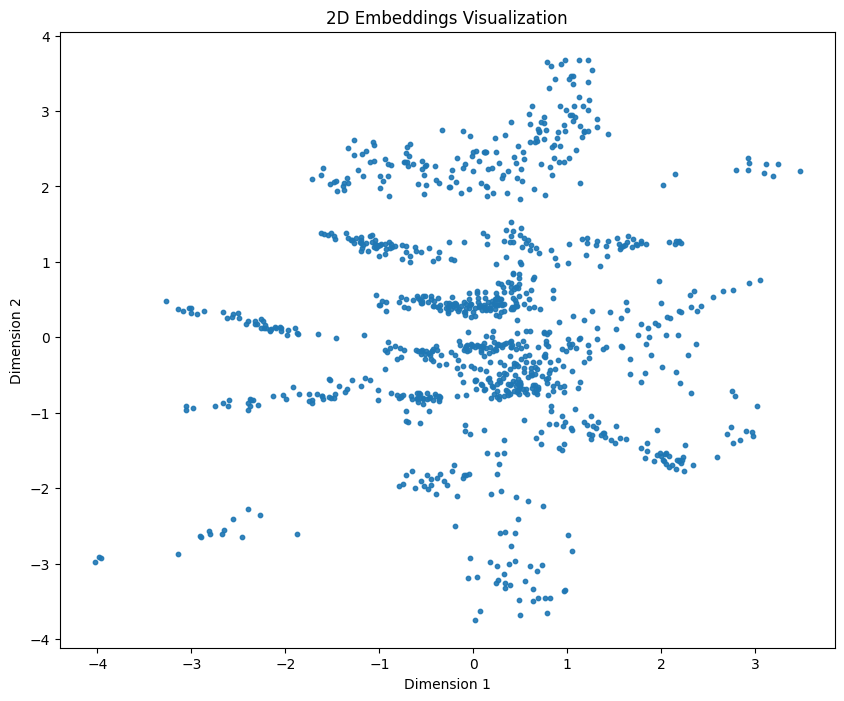

In [ ]:
# Create a scatter plot
plt.figure(figsize=(10, 8))
plt.scatter(mu[:, 0], mu[:, 1], s=10, alpha=0.9)

# Add axis labels
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')

# Add a title
plt.title('2D Embeddings Visualization')

# Show the plot
plt.show()

Now we decode the $\mu$'s

In [32]:
with torch.no_grad():
  log_p = model.decoder(mu)
  p = torch.exp(log_p)
p.shape

torch.Size([1000, 107, 21])

In [34]:
# covert probablities into actual protein sequences by choosing the most likely amino acid at each position.
max_prob_idx = torch.argmax(p, -1)
seqs = []
for i in range(100):
    seq = [idx_to_aa_list[idx] for idx in max_prob_idx[i,:]]
    print("".join(seq))
    seqs.append("".join(seq))

KLREEIDEVLGDDRLPTEEDLKKLPYLDAVIKETLRLYPPVPGLPREATEDTTLGGYTIPKGTTVLVNIWAIHRDPEVWPDPEEFDPERFLDENG.KGPPFALLL..
KLREEIDEVLGDDRLPTEEDLKKLPYLDAVIKETLRLYPPVPGLPREATEDTTLGGYTIPKGTTVLVNIWAIHRDPEVWPDPEEFDPERFLDENG.KGPPFALLL..
KLREEIDEVLGDDRLPTEEDLKKLPYLDAVIKETLRLYPPVPGLPREATEDTTLGGYTIPKGTTVLVNIWAIHRDPEVWPDPEEFDPERFLDENG.KGPPFALLL..
KLREEIDEVLGDDRLPTEEDLKKLPYLDAVIKETLRLYPPVPGLPREATEDTTLGGYTIPKGTTVLVNIWAIHRDPEVWPDPEEFDPERFLDENG.KGPPFALLL..
KLREEIDEVLGDDRLPTEEDLKKLPYLDAVIKETLRLYPPVPGLPREATEDTTLGGYTIPKGTTVLVNIWAIHRDPEVWPDPEEFDPERFLDENG.KGPPFALLL..
KLREEIDEVLGDDRLPTEEDLKKLPYLDAVIKETLRLYPPVPGLPREATEDTTLGGYTIPKGTTVLVNIWAIHRDPEVWPDPEEFDPERFLDENG.KGPPFALLL..
KLREEIDEVLGDDRLPTEEDLKKLPYLDAVIKETLRLYPPVPGLPREATEDTTLGGYTIPKGTTVLVNIWAIHRDPEVWPDPEEFDPERFLDENG.KGPPFALLL..
KLREEIDEVLGDDRLPTEEDLKKLPYLDAVIKETLRLYPPVPGLPREATEDTTLGGYTIPKGTTVLVNIWAIHRDPEVWPDPEEFDPERFLDENG.KGPPFALLL..
KLREEIDEVLGDDRLPTEEDLKKLPYLDAVIKETLRLYPPVPGLPREATEDTTLGGYTIPKGTTVLVNIWAIHRDPEVWPDPEEFDPERFLDENG.KGPPFALLL..
KLREEIDEVLGDDRLPTEEDLKKLPYLD

In [20]:
# Proportion of amino acids correctly recovered
torch.sum(real == max_prob_idx)/real.nelement()

tensor(0.3764)

In [21]:
# What's the proportion of characters that match the original
correct = 0
total = 0
for (seq, real_seq) in zip(seqs, real_seqs):
  correct += sum([real_c == recon_c for (real_c, recon_c) in zip(seq, real_seq)])
  total += len(seq)
print(f"correct: {correct}")
print(f"total: {total}")
print(f"Percentage correct: {np.round(100*correct/total, 2)}")

correct: 986
total: 2675
Percentage correct: 36.86
